# Loan approval prediction

This project aims to analyze loan approval decisions using applicant information such as number of dependents, education level, employment status, annual income, loan amount, tenure of loan, credit score (CIBIL) and asset values. The objective is to understand which factors are most strongly associated with loan approval and how these relationships can be leveraged to build predictive models. 

$\textbf{Target variable:}$ loan_status (Approved / Rejected).

$\textbf{Main steps in this notebook:}$

- Load and inspect the dataset.
- Perform data cleaning and handle anomalies.
- Add a small feature to capture missing/unknown residential asset information.
- Perform exploratory data analysis.
- Prepare data and train predictive models.


## Libraries

In [285]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from phik import report


## Data overview

In [286]:
# Loading the dataset
df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [287]:
# Checking the shape of the dataset
df.shape

(4269, 13)

In [288]:
# Checking for missing values
df.isna().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [289]:
# Checking the data types
df.dtypes

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

## Data Quality & Cleaning

In [290]:
# Removing leading spaces in column names.
df.columns = df.columns.str.strip()

Removing `loan_id` as it's only an identifier and should not be used as a predictive feature.

In [291]:
df.drop(["loan_id"], axis = 1, inplace = True)

The target column is `loan_status`, which indicates whether a loan application was approved or rejected. For modeling purposes, this variable is encoded as a binary outcome.

In [292]:
df['loan_status'] = df['loan_status'].map({' Approved': 1, ' Rejected':0})
df['loan_status'].value_counts()

loan_status
1    2656
0    1613
Name: count, dtype: int64

The target variable shows moderate class imbalance, with approved loans being more common than rejected ones. The imbalance is not severe and does not requiere special resampling techniques.

Summary statistics are examined to identify potential data quality issues such as unexpected ranges or extreme values.

In [293]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


From the summary statistics, only `residential_assets_value` exhibits negative values, while all other asset-related variables have a minimum of zero.

In [294]:
# How many negative value rows does residential_assets_value have?
print((df['residential_assets_value'] < 0).sum())

28


In [295]:
# Is -100000 the only placeholder value?
df.loc[df['residential_assets_value'] < 0, 'residential_assets_value'].unique()

array([-100000])

Noticed that some rows have `residential_assets_value = -100000`, which is not realistic. This is likely a placeholder for missing/unknown data.

Below I:
1. Inspect a few example rows with the placeholder value.
2. Quantify how common it is
3. Create a feature that distinguishes Unknown vs 0 vs positive values
4. Replace the placeholder with a the median of valid values.

In [296]:
df[df['residential_assets_value'] == df['residential_assets_value'].min()].head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
59,4,Not Graduate,Yes,5500000,18200000,16,797,-100000,4900000,18600000,4800000,1
196,4,Not Graduate,Yes,400000,1500000,2,669,-100000,600000,900000,500000,1
559,2,Graduate,Yes,200000,500000,6,885,-100000,0,300000,200000,0
702,4,Graduate,Yes,6300000,23900000,6,899,-100000,11400000,20600000,6700000,1
737,2,Graduate,Yes,900000,2500000,16,458,-100000,100000,3200000,1100000,0


In [297]:
# How many placeholder values are in total?
len(df[df['residential_assets_value'] == df['residential_assets_value'].min()])

28

In [298]:
# How much of the dataset contains placeholder values?
len(df[df['residential_assets_value'] == df['residential_assets_value'].min()]) / df.shape[0]

0.006558913094401499

The placeholder values make up a small share of the dataset. I chose not to delete these records because they contained valuable signals in other areas, such as commerical assets. I implemented a hybrid approach. I imputed the missing values with the median to keep the numerical scale consistent and created a new categorical feature to allow the model to distinguish between non-owners and unknown data points.

In [299]:
def get_asset_status(row):
    if row['residential_assets_value'] == -100000:
        return 'Unknown'
    elif row['residential_assets_value'] == 0:
        return 'No_Res_Assets'
    else:
        return 'Has_Res_Assets'

df['res_asset_status'] = df.apply(get_asset_status, axis = 1)

In [300]:
# Impute placeholder with median of valid values.
res_median = df[df['residential_assets_value'] >= 0]['residential_assets_value'].median()
df['residential_assets_value'] = df['residential_assets_value'].replace(-100000, res_median)

## Exploratory Data Analysis

### Target distribution

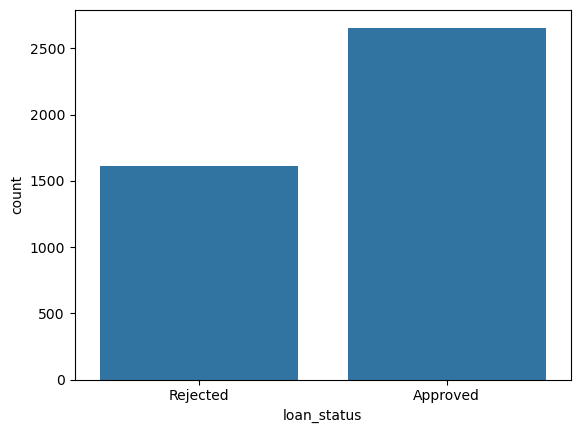

In [301]:
sns.countplot(data = df, x='loan_status')
plt.xticks([0,1], ['Rejected', 'Approved'])
plt.show()

This dataset contains more approved than rejected loan applications, though the difference is moderate rather than extreme.

### Income and Loan Approval

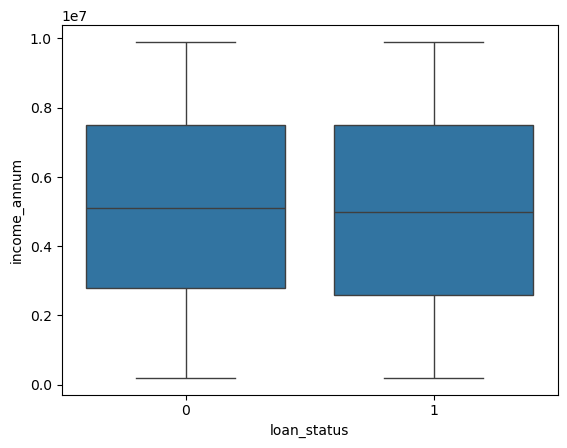

In [302]:
sns.boxplot(data = df, x = 'loan_status', y = 'income_annum')
plt.show()

The income distributions for approved and rejected loans show substantial overlap, with similar medians and spread across both groups. This suggests that annual income alone might not be a strong distinguishing factor in loan approval decisions.

### Loan approval by education

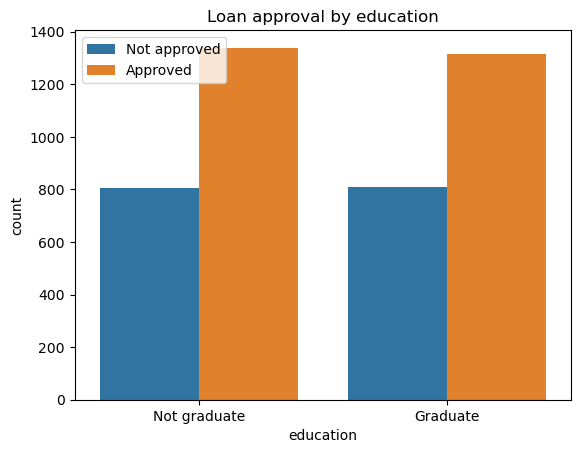

In [303]:
sns.countplot(data = df, x = 'education', hue = 'loan_status')
plt.legend(["Not approved", "Approved"], loc = 'upper left')
plt.title("Loan approval by education")
plt.xticks([0,1], ["Not graduate", "Graduate"])
plt.show()

Loan approval rates appear similar for graduate and non-graduate applicants. This suggests that education level does not strongly influence loan approval decisions in this dataset. 

### Loan approval by self-employement

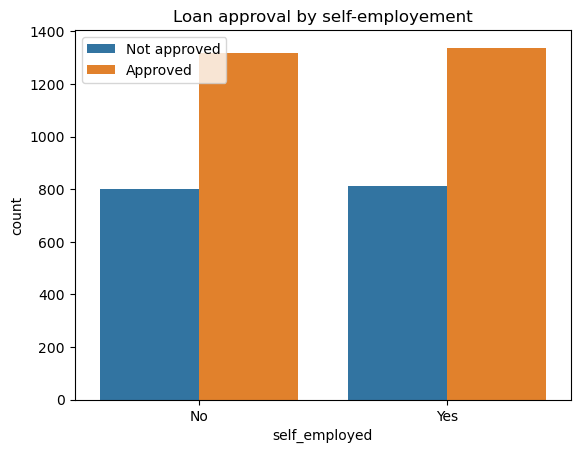

In [305]:
sns.countplot(data = df, x = 'self_employed', hue = 'loan_status')
plt.legend(["Not approved", "Approved"], loc = 'upper left')
plt.title("Loan approval by self-employement")
plt.xticks([0,1], ["No", "Yes"])
plt.show()

A similar pattern is observed for self-employed and non-self-employed applicants. Approval rates do not differ substantially between the two groups.

### Credit score and Loan approval

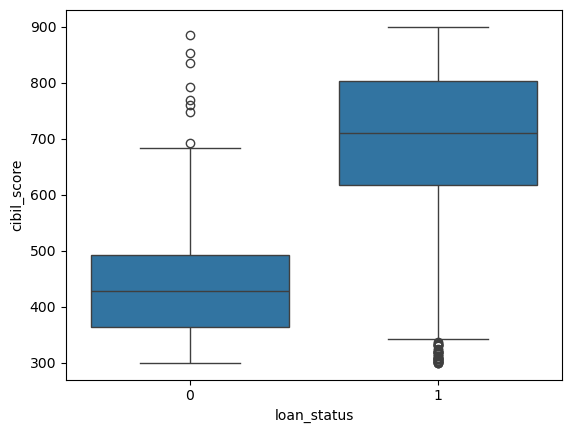

In [306]:
sns.boxplot(data = df, x = 'loan_status', y = 'cibil_score')
plt.show()

The boxplot shows a clear separation in CIBIL scores between approvad and rejected loan applications. Approved loans have substantially higher median CIBIL scores than rejected ones. However a small number of high-score applicants are still rejected and some low-score applicants are approved.

### Relationship Between Income and Asset Values

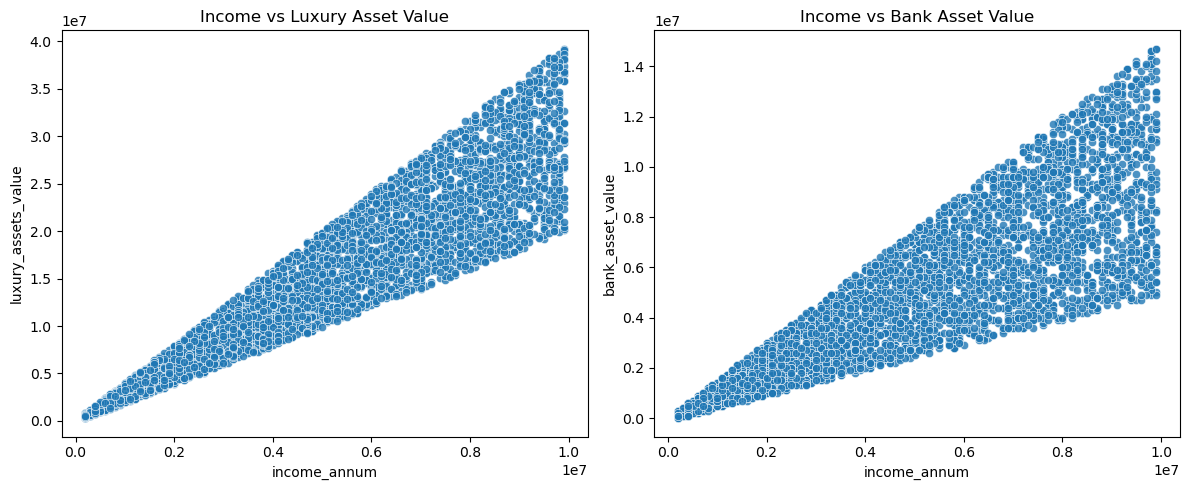

In [307]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(
    data = df,
    x = 'income_annum',
    y = 'luxury_assets_value',
    alpha = 0.8,
    ax = axes[0]
)

axes[0].set_title("Income vs Luxury Asset Value")
sns.scatterplot(
    data = df, 
    x = 'income_annum',
    y = 'bank_asset_value',
    alpha = 0.8,
    ax = axes[1]
)
axes[1].set_title("Income vs Bank Asset Value")
plt.tight_layout()
plt.show()

The scatterplots indicate a positive association between annual income and both luxury and bank asset values. While higher-income applicants tend to report larger asset values, the relationship shows considerable dispersion, indicating substantial variability across applicants.

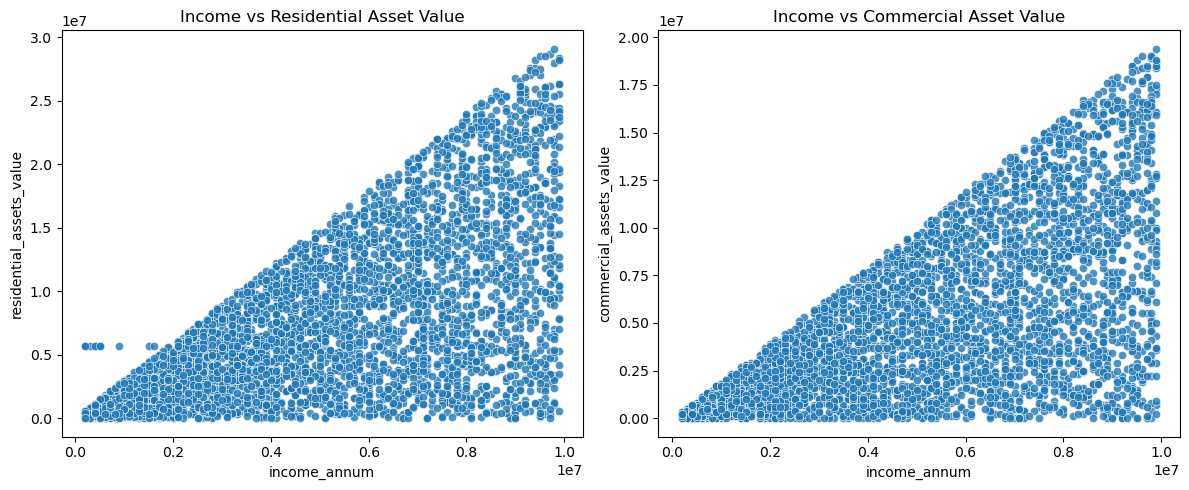

In [308]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(
    data = df,
    x = 'income_annum',
    y = 'residential_assets_value',
    alpha = 0.8,
    ax = axes[0]
)

axes[0].set_title("Income vs Residential Asset Value")
sns.scatterplot(
    data = df, 
    x = 'income_annum',
    y = 'commercial_assets_value',
    alpha = 0.8,
    ax = axes[1]
)
axes[1].set_title("Income vs Commercial Asset Value")
plt.tight_layout()
plt.show()

The dispersion of asset values increases with income. At lower income levels, asset ownership is tightly constrained, resulting in limited variablity. At higher income levels, applicants have more flexibility in how income is allocated, leading to substantially greater variation in reported asset values.

### Heatmap

To assess associations between variables further, a $\phi_k$ (phi-k) correlation matrix is used. Unlike Pearson correlation, $\phi_k$ can capture non-linear relationships and handle both categorical and numerical variables. 

In classification problems such as loan approval, decision boundaries can often be threshold-based rather than linear. As a result, $\phi_k$ may indicate stronger associations than traditional linear correlation measures.

Note: While the $\phi_k$ correlation matrix is excellent for capturing non-linear associations and mixed data types, it is important to note that it measures strength of association, not directionality. A high $\phi_k$ score tells us that variables A and B are strongly correlated, but it does not specify if the relationship is positive or negative.

interval columns not set, guessing: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


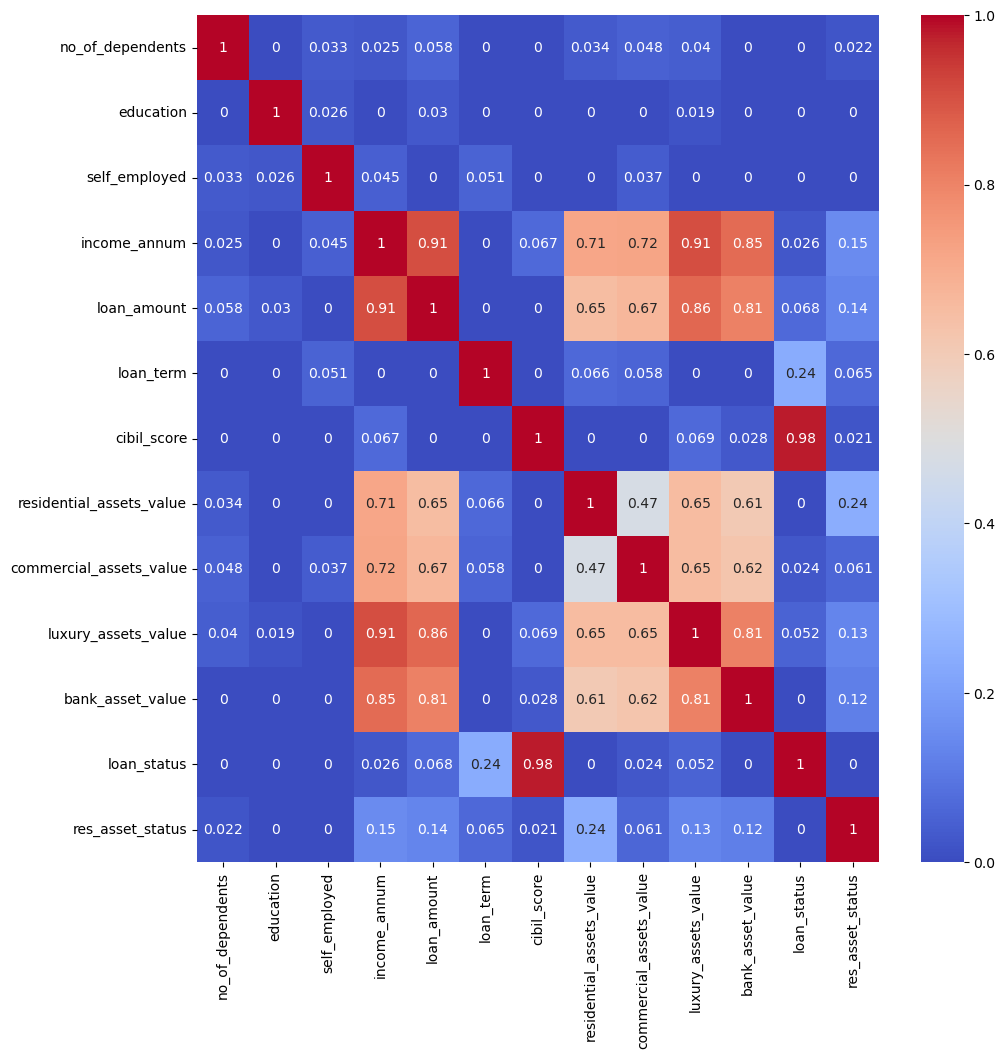

In [269]:

phik_matrix = df.phik_matrix()
plt.figure(figsize = (11,11))
sns.heatmap(phik_matrix, annot = True, cmap = "coolwarm")
plt.show()

The correlation shows a very strong relationship between `cibil_score` and `loan_status` (correlation 0.98). 

This indicates that credit score is the dominant factor in loan approval decisions. In practice, this is realistic, as lenders heavily rely on credit scores when evaluating applications. 

However, this also means that any predictive model may archieve high accuracy mainly by learning the credit score threshold, while other features play a secondary role.

To better understand the role of credit score, models will later be trained both with and without `cibil_score`. This allows seperating overall predictive accuracy from the contribution of other applicant charecteristics.

Note: High correlation does not imply causation. In this case, the relationship is expected, as credit score is designed to summarize repayment risk and is directly used in lending decisions.

Beyond the credit score, there is a high correlation between income, loan amount and various asset value variables, with $\phi_k$ correlations ranging from approxiamtely 0.70 to 0.91. This means they often describe the same underlying financial situation. 

For modeling, using many similar features can make results harder to interpret.
Therefore, asset variables may be combined into a single measure, or income can be used as a simple summary of financial strength.

## Model Preparation

### Train Test Split

Two feature sets are created: one including the credit score (CIBIL) and one exluding it. This allows assessing how strongly model performance depends on credit score alone.

In [309]:
X = df.drop(columns = ['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# with CIBIL
X_train_all = X_train
X_test_all = X_test

# without CIBIL
X_train_nc = X_train.drop(columns = ['cibil_score'])
X_test_nc = X_test.drop(columns=['cibil_score'])


### Encoding variables 

Machine learning models need numerical input.

Instead of manually mapping categories to 0/1, I use One-Hot Encoding:
- It creates a seperate column for each category.
- This avoids accidentally giving categories an artificial order.

In [310]:

categorical_cols = ['education', 'self_employed', 'res_asset_status']
numeric_cols_all = [c for c in X_train_all.columns if c not in categorical_cols]
numeric_cols_nc = [c for c in X_train_nc.columns if c not in categorical_cols]

preprocess_all = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols_all)
    ]
)

preprocess_nc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols_nc)
    ]
)


## Model Training

### Model Building

Three models are used in this analysis: Logistic Regression, Random Forest, and
XGBoost. Logistic Regression serves as a simple and interpretable baseline. Random Forest and XGBoost are tree-based models capable of capturing non-linear
relationships and interactions between features. Using models of increasing complexity allows comparing performance and assessing whether more complex methods provide meaningful improvements over simpler approaches.Each model is evaluated using two feature sets: one including the credit score (CIBIl) and one exluding it. This allows assessing how strongly predictive performance depends on credit score across models of increasing complexity.

In [311]:
# Logistic regression with all variables
lr_all = Pipeline(
    steps = [
        ('preprocess', preprocess_all),
        ('model', LogisticRegression(max_iter=300, class_weight='balanced'))
    ]
)


lr_all.fit(X_train_all, y_train)

y_pred_lr_all = lr_all.predict(X_test_all)
y_proba_lr_all = lr_all.predict_proba(X_test_all)[:,1]

acc_lr_all  = accuracy_score(y_test, y_pred_lr_all)
auc_lr_all = roc_auc_score(y_test, y_proba_lr_all)

acc_lr_all, auc_lr_all

(0.7962529274004684, 0.8658469037332448)

In [312]:
# Logistic regression without cibil score 
lr_nc = Pipeline(
    steps = [
        ('preprocess', preprocess_nc),
        ('model', LogisticRegression(max_iter=300, class_weight='balanced'))
    ]
)

lr_nc.fit(X_train_nc, y_train)

y_pred_lr_nc = lr_nc.predict(X_test_nc)
y_proba_lr_nc = lr_nc.predict_proba(X_test_nc)[:,1]

acc_lr_nc  = accuracy_score(y_test, y_pred_lr_nc)
auc_lr_nc = roc_auc_score(y_test, y_proba_lr_nc)

acc_lr_nc, auc_lr_nc

(0.5281030444964872, 0.5334581052165142)

Random Forest is used to capture non-linear relationships and interactions between features that may not be adequately modeled by logistic regression.

In [313]:
# Random forest with all variables
rf_all = Pipeline(
    steps = [
        ('preprocess', preprocess_all),
        ('model', RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight='balanced'
        ))
    ]
)

rf_all.fit(X_train_all, y_train)

y_pred_rf_all = rf_all.predict(X_test_all)
y_proba_rf_all = rf_all.predict_proba(X_test_all)[:,1]

acc_rf_all  = accuracy_score(y_test, y_pred_rf_all)
auc_rf_all = roc_auc_score(y_test, y_proba_rf_all)

acc_rf_all, auc_rf_all

(0.9812646370023419, 0.9988368228647391)

In [314]:
# Random forest without cibil score
rf_nc = Pipeline(
    steps = [
        ('preprocess', preprocess_nc),
        ('model', RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight='balanced'
        ))
    ]
)

rf_nc.fit(X_train_nc, y_train)

y_pred_rf_nc = rf_nc.predict(X_test_nc)
y_proba_rf_nc = rf_nc.predict_proba(X_test_nc)[:,1]

acc_rf_nc  = accuracy_score(y_test, y_pred_rf_nc)
auc_rf_nc = roc_auc_score(y_test, y_proba_rf_nc)

acc_rf_nc, auc_rf_nc

(0.5960187353629977, 0.5985114830945759)

XGBoost was included due to its strong performance in structured tabular data and its ability to model complex, non-linear decision boundaries while controlling for overfitting.

In [315]:
# XGBoost with all variables
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
xgb_all = Pipeline(
    steps = [
        ('preprocess', preprocess_all),
        ('model', XGBClassifier(
            n_estimators = 200,
            learning_rate = 0.05,
            subsample = 0.8,
            colsample_bytree = 0.8,
            eval_metric = 'logloss',
            random_state = 42,
            scale_pos_weight = scale_pos_weight
        ))
    ]
)

xgb_all.fit(X_train_all, y_train)

y_pred_xgb_all = xgb_all.predict(X_test_all)
y_proba_xgb_all = xgb_all.predict_proba(X_test_all)[:,1]

acc_xgb_all  = accuracy_score(y_test, y_pred_xgb_all)
auc_xgb_all = roc_auc_score(y_test, y_proba_xgb_all)

acc_xgb_all, auc_xgb_all

(0.9789227166276346, 0.9987464507063605)

In [316]:
# XGBoost without cibil score
xgb_nc = Pipeline(
    steps = [
        ('preprocess', preprocess_nc),
        ('model', XGBClassifier(
            n_estimators = 200,
            learning_rate = 0.05,
            subsample = 0.8,
            colsample_bytree = 0.8,
            eval_metric = 'logloss',
            random_state = 42,
            scale_pos_weight = scale_pos_weight
        ))
    ]
)

xgb_nc.fit(X_train_nc, y_train)

y_pred_xgb_nc = xgb_nc.predict(X_test_nc)
y_proba_xgb_nc = xgb_nc.predict_proba(X_test_nc)[:,1]

acc_xgb_nc  = accuracy_score(y_test, y_pred_xgb_nc)
auc_xgb_nc = roc_auc_score(y_test, y_proba_xgb_nc)

acc_xgb_nc, auc_xgb_nc

(0.5550351288056206, 0.5731227370520018)

## Model Comparison and Interpretation

In [317]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy (all variables)': [acc_lr_all,acc_rf_all, acc_xgb_all],
    'ROC-AUC (all variables)': [auc_lr_all, auc_rf_all, auc_xgb_all],
    'Accuracy (no cibil score)': [acc_lr_nc, acc_rf_nc, acc_xgb_nc],
    'ROC-AUC (no cibil score)': [auc_lr_nc, auc_rf_nc, auc_xgb_nc]
})

results

,Model,Accuracy (all variables),ROC-AUC (all variables),Accuracy (no cibil score),ROC-AUC (no cibil score)
0,Logistic Regression,0.796253,0.865847,0.528103,0.533458
1,Random Forest,0.981265,0.998837,0.596019,0.598511
2,XGBoost,0.978923,0.998746,0.555035,0.573123


Model performance differs substantially depending on whether the credit score
(CIBIL) is included. When all variables are used, tree-based models achieve
near-perfect performance, indicating that credit score provides a very strong
signal for loan approval decisions. Logistic Regression also performs well but
with lower accuracy and ROC-AUC.

When credit score is excluded, performance drops across all models, with
ROC-AUC values close to random guessing. This suggests that other applicant
features such as income, assets, and demographics carry limited standalone
predictive power.

Overall, these results indicate that credit score is the dominant factor in loan
approval decisions within this dataset.


## Conclusion

This analysis examined loan approval decisions using applicant demographic,
financial, and credit-related information. Exploratory analysis revealed that
credit score (CIBIL) exhibits a clear separation between approved and rejected
applications, while other variables such as income, asset values, education, and
employment status show substantial overlap between the two groups.

Modeling results reinforce these findings. When credit score is included, all
models perform well, with tree-based methods achieving near-perfect predictive
performance. In contrast, excluding credit score leads to a sharp decline in
performance across all models, with accuracy and ROC-AUC values approaching
random classification. This indicates that credit score is the dominant driver of
loan approval decisions in this dataset, while other features contribute limited
standalone predictive power.

Overall, the results suggest that loan approval decisions in this dataset are
largely determined by credit score, with additional applicant characteristics
playing a secondary role. While more complex models achieve higher accuracy, a
simpler and more interpretable model such as Logistic Regression may be sufficient
when credit score is available. Future work could explore alternative data
sources, additional behavioral features, or fairness considerations to better
understand decision-making beyond credit score alone.
